In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


### STEP 1 : 시계열 데이터 준비
칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

Date
2017-01-02    156500.0
2017-01-03    158000.0
2017-01-04    154500.0
2017-01-05    157500.0
2017-01-06    157500.0
Name: Close, dtype: float64 Date
2017-01-02    45800.0
2017-01-03    47250.0
2017-01-04    46500.0
2017-01-05    46950.0
2017-01-06    48000.0
Name: Close, dtype: float64 0    10350
1    10350
2    10500
3    10500
4    10700
Name: Close, dtype: int64


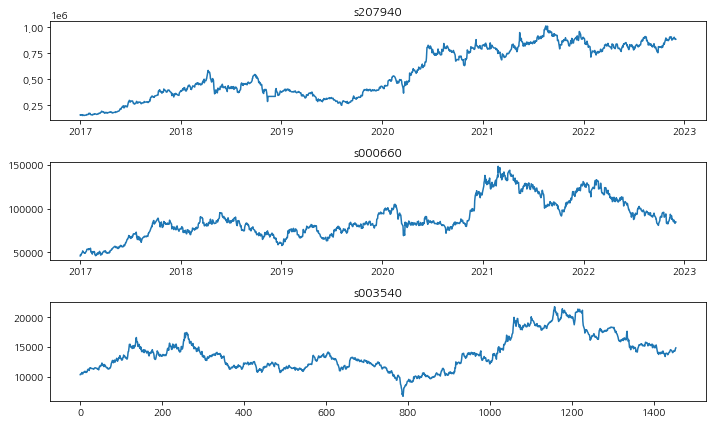

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams  #from matplotlib import rcParams
import os, copy
import warnings

warnings.filterwarnings(action='ignore')                     

# Time Series 생성: 삼성바이오로직스 207940, SK하이닉스000660, lg화학051910
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data'

삼성바이오로직스 = '207940.csv'
SK하이닉스 = '000660.csv'
대신증권 = '003540.csv'

df207940 = pd.read_csv(os.path.join(dataset_filepath,삼성바이오로직스), index_col='Date', parse_dates=True)
df000660 = pd.read_csv(os.path.join(dataset_filepath,SK하이닉스), index_col='Date', parse_dates=True)
df003540 = pd.read_csv(os.path.join(dataset_filepath,대신증권), parse_dates=True)

# 3종목 dict에 종가만 Series에담음
stockdict = dict(s207940=df207940['Close'],s000660=df000660['Close'], s003540=df003540['Close'])
print(stockdict['s207940'].head(),stockdict['s000660'].head(),stockdict['s003540'].head())

# plot
rcParams['figure.figsize'] = 10, 6  
rcParams['font.family'] = 'NanumGothic'
fig, ax = plt.subplots(3,1)
for i,(k,v) in enumerate(stockdict.items()):
    ax[i].plot(stockdict[k])
    ax[i].title.set_text(k)  
plt.tight_layout()
plt.show()


### STEP 2 : 각종 전처리 수행
결측치 처리
로그 변환

In [3]:
# 결측치 처리
for k,v in stockdict.items():
    stockdict[k] = v.interpolate(method='time')  # 직전time,직후time값 평균치
    print(f"stockdict[{k}]",stockdict[k][v.isna()])  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.


stockdict[s207940] Series([], Name: Close, dtype: float64)
stockdict[s000660] Series([], Name: Close, dtype: float64)
stockdict[s003540] Series([], Name: Close, dtype: int64)


In [4]:
# 로그 변환
stockdict_log = {}
for k,v in stockdict.items():
    stockdict_log[k + '_log'] = np.log(v)   #ts_log = np.log(ts)
    print(f"stockdict_log[{k + '_log'}]",stockdict_log[k + '_log'].head())      #ts_log.head()

stockdict_log[s207940_log] Date
2017-01-02    11.960811
2017-01-03    11.970350
2017-01-04    11.947949
2017-01-05    11.967181
2017-01-06    11.967181
Name: Close, dtype: float64
stockdict_log[s000660_log] Date
2017-01-02    10.732039
2017-01-03    10.763208
2017-01-04    10.747208
2017-01-05    10.756838
2017-01-06    10.778956
Name: Close, dtype: float64
stockdict_log[s003540_log] 0    9.244742
1    9.244742
2    9.259131
3    9.259131
4    9.277999
Name: Close, dtype: float64


## STEP 3 : 시계열 안정성 분석
정성적 그래프 분석
정량적 Augmented Dicky-Fuller Test
시계열 분해(Time Series Decomposition)
Residual 안정성 확인

In [5]:
# 통계량 안정성 정성적 시각적확인 plot
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


In [6]:
# adf 메소드 및 함수
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    print(dftest)
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
 

<< s207940_log종목 정성적분석입니다.>>


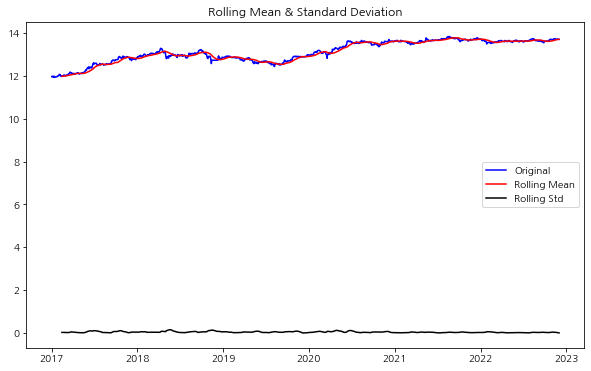

<< s000660_log종목 정성적분석입니다.>>


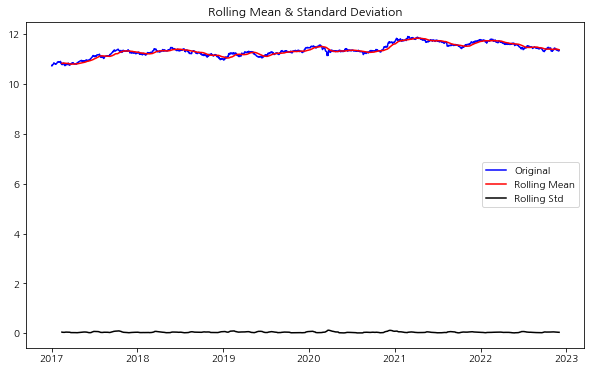

<< s003540_log종목 정성적분석입니다.>>


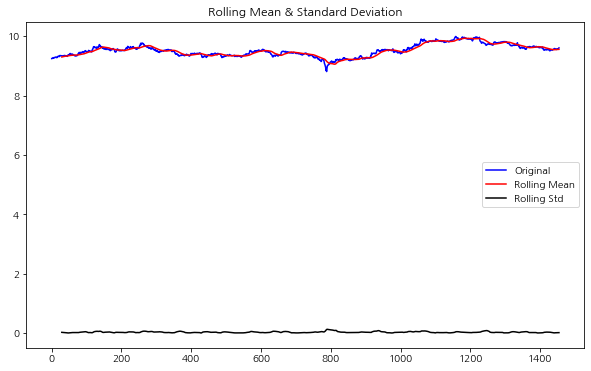

<< s207940_log종목 정량적분석입니다.>>
(-2.036041010845423, 0.2709972894342727, 0, 1450, {'1%': -3.4348678719530934, '5%': -2.863535337271721, '10%': -2.5678323015457787}, -6312.961317915693)
Results of Dickey-Fuller Test:
Test Statistic                   -2.036041
p-value                           0.270997
#Lags Used                        0.000000
Number of Observations Used    1450.000000
Critical Value (1%)              -3.434868
Critical Value (5%)              -2.863535
Critical Value (10%)             -2.567832
dtype: float64
<< s000660_log종목 정량적분석입니다.>>
(-2.6482152345527754, 0.08343587173987921, 0, 1450, {'1%': -3.4348678719530934, '5%': -2.863535337271721, '10%': -2.5678323015457787}, -6721.920758362352)
Results of Dickey-Fuller Test:
Test Statistic                   -2.648215
p-value                           0.083436
#Lags Used                        0.000000
Number of Observations Used    1450.000000
Critical Value (1%)              -3.434868
Critical Value (5%)              -2.86353

In [7]:
# 정성적 그래프 분석
for k,v in stockdict_log.items():
    print(f"<< {k}종목 정성적분석입니다.>>")
    plot_rolling_statistics(v, window=30)

#정량적 Augmented Dicky-Fuller Test
for k,v in stockdict_log.items():
    print(f"<< {k}종목 정량적분석입니다.>>")
    augmented_dickey_fuller_test(v)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

# 시계열분해데이터 저장용 dict 생성
stockdict_log_decomp = {}

for k,v in stockdict_log.items():
    print(f"<< {k}종목 시계열 분해입니다.>>")
    decomposition = seasonal_decompose(v, model='multiplicative', period = 30) 
    print(f"{k}_decomposition", decomposition)
    stockdict_log_decomp[k + '_trend'] = decomposition.trend
    stockdict_log_decomp[k + '_seasonal'] = decomposition.seasonal
    stockdict_log_decomp[k + '_residual'] = decomposition.resid
    
print("stockdict_log_decomp", stockdict_log_decomp)    
    

s207940_log_trend trend
s207940_log_seasonal seasonal
s207940_log_residual residual

<< s207940_log_residual 종목의 Residual 안정성확인입니다.>>


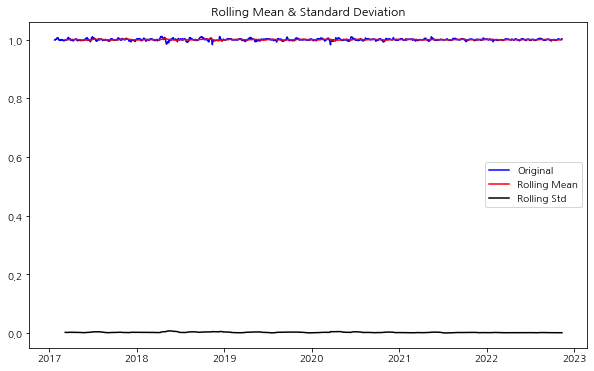

(-12.36972838523299, 5.314751076412742e-23, 11, 1409, {'1%': -3.434999576596685, '5%': -2.8635934599975106, '10%': -2.5678632530961614}, -13588.62313735257)
Results of Dickey-Fuller Test:
Test Statistic                -1.236973e+01
p-value                        5.314751e-23
#Lags Used                     1.100000e+01
Number of Observations Used    1.409000e+03
Critical Value (1%)           -3.435000e+00
Critical Value (5%)           -2.863593e+00
Critical Value (10%)          -2.567863e+00
dtype: float64
s000660_log_trend trend
s000660_log_seasonal seasonal
s000660_log_residual residual

<< s000660_log_residual 종목의 Residual 안정성확인입니다.>>


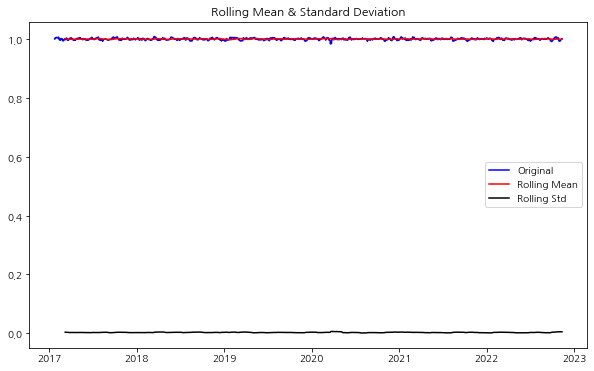

(-11.438840265258813, 6.250547244542454e-21, 22, 1398, {'1%': -3.4350362287526157, '5%': -2.863609634548904, '10%': -2.567871866451358}, -13640.411548586268)
Results of Dickey-Fuller Test:
Test Statistic                -1.143884e+01
p-value                        6.250547e-21
#Lags Used                     2.200000e+01
Number of Observations Used    1.398000e+03
Critical Value (1%)           -3.435036e+00
Critical Value (5%)           -2.863610e+00
Critical Value (10%)          -2.567872e+00
dtype: float64
s003540_log_trend trend
s003540_log_seasonal seasonal
s003540_log_residual residual

<< s003540_log_residual 종목의 Residual 안정성확인입니다.>>


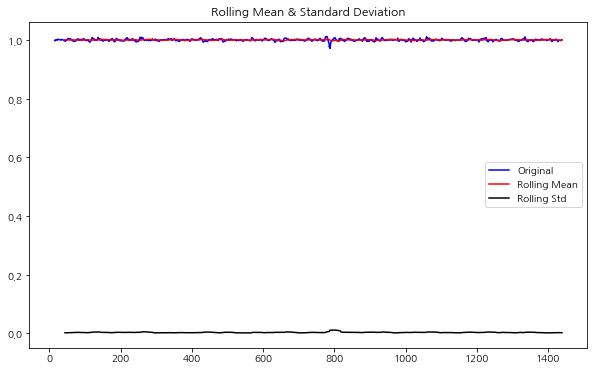

(-14.564515129112094, 4.735691264825326e-27, 8, 1416, {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}, -13758.14519918211)
Results of Dickey-Fuller Test:
Test Statistic                -1.456452e+01
p-value                        4.735691e-27
#Lags Used                     8.000000e+00
Number of Observations Used    1.416000e+03
Critical Value (1%)           -3.434977e+00
Critical Value (5%)           -2.863583e+00
Critical Value (10%)          -2.567858e+00
dtype: float64


In [8]:
# Residual 안정성 확인
for k,v in stockdict_log_decomp.items():
    # key == 'residual'인 경우만 실행
    print(k,k.split('_')[-1])
    if k.split('_')[-1] == 'residual':
        print()
        print('='*80)
        print(f"<< {k} 종목의 Residual 안정성확인입니다.>>")
        plot_rolling_statistics(v, window=30)
        v.dropna(inplace = True)
        augmented_dickey_fuller_test(v)
     

### STEP 4 : 학습, 테스트 데이터셋 생성
학습, 테스트 데이터셋 분리

stock_log_data[s207940_log_train_data].shape, (1305,) stock_log_data[s207940_log_test_data].shape, (146,)
stock_log_data[s000660_log_train_data].shape, (1305,) stock_log_data[s000660_log_test_data].shape, (146,)
stock_log_data[s003540_log_train_data].shape, (1309,) stock_log_data[s003540_log_test_data].shape, (146,)


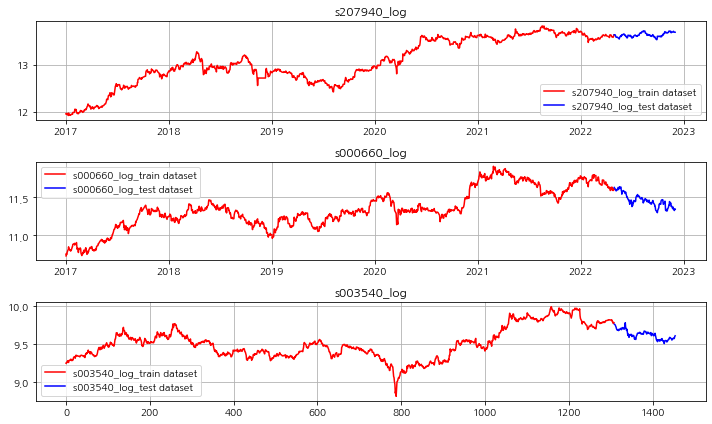

In [9]:
# train_data, test_data 
# train,test 분리된 data의  dict 생성
stock_log_data = {}

rcParams['figure.figsize'] = 10, 6  
#rcParams['font.family'] = 'NanumGothic'
fig, ax = plt.subplots(3,1)

for i,(k,v) in enumerate(stockdict_log.items()):
    stock_log_data[k + '_train_data'],stock_log_data[k + '_test_data'] =  v[:int(len(v)*0.9)], v[int(len(v)*0.9):]
    print(f"stock_log_data[{k}_train_data].shape,",stock_log_data[k + '_train_data'].shape,
          f"stock_log_data[{k}_test_data].shape,",stock_log_data[k + '_test_data'].shape )  

    # plot
    ax[i].plot(stock_log_data[k + '_train_data'], c='r', label=f'{k}_train dataset') 
    ax[i].plot(stock_log_data[k + '_test_data'], c='b', label=f'{k}_test dataset')
    ax[i].title.set_text(k) 
    ax[i].legend() 
    ax[i].grid(True)    
    
plt.tight_layout()
plt.show()     


### STEP 5 : 적정 ARIMA 모수 찾기
ACF, PACF 그려보기 -> p,q 구하기
차분 안정성 확인 -> d 구하기


<< 0. s207940_log 종목의  p,q 구하기용 ACF, PACF 챠트확인입니다.>>


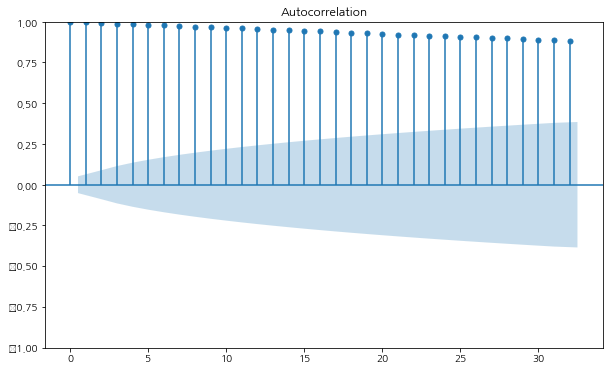

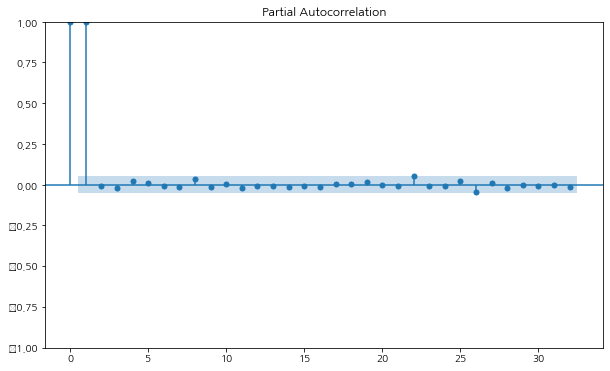


<< 1. s000660_log 종목의  p,q 구하기용 ACF, PACF 챠트확인입니다.>>


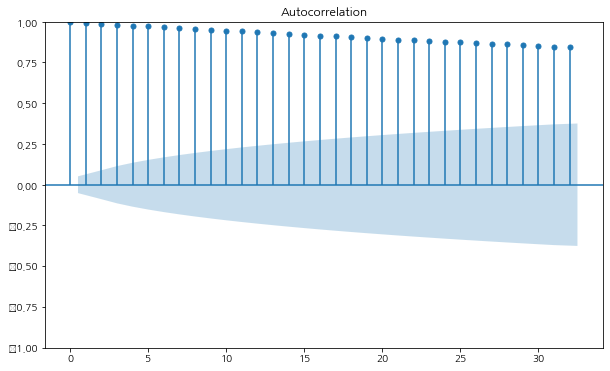

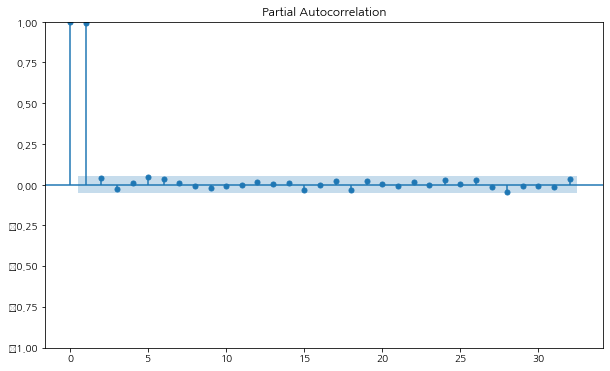


<< 2. s003540_log 종목의  p,q 구하기용 ACF, PACF 챠트확인입니다.>>


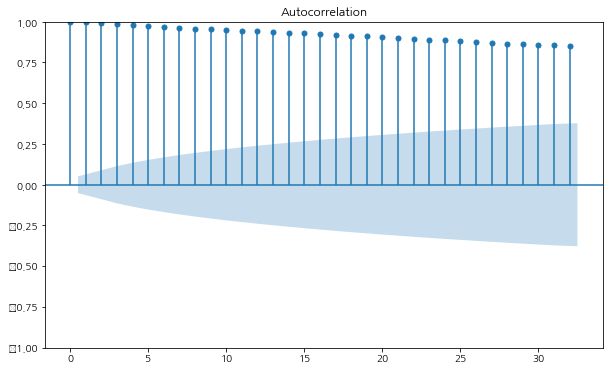

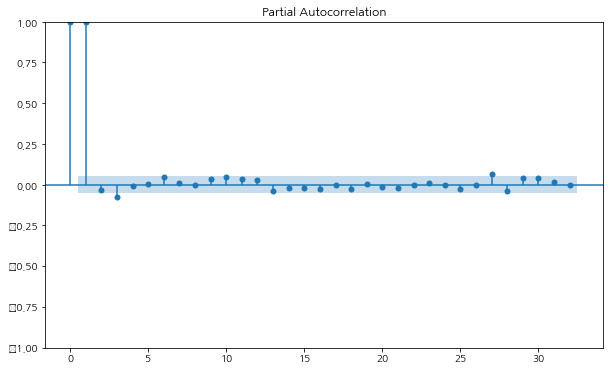

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for i,(k,v) in enumerate(stockdict_log.items()):
    print()
    print('='*80)
    print(f"<< {i}. {k} 종목의  p,q 구하기용 ACF, PACF 챠트확인입니다.>>")
    plot_acf(v)
    plot_pacf(v)
    plt.show()



<< 0. s207940_log 종목의 d 구하기용 차분안정성확인입니다.>>


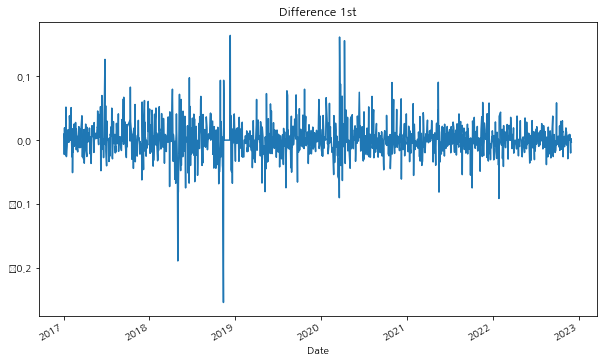

(-37.44926356734389, 0.0, 0, 1449, {'1%': -3.4348709954268384, '5%': -2.863536715724964, '10%': -2.567833035595811}, -6307.982477253172)
Results of Dickey-Fuller Test:
Test Statistic                  -37.449264
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1449.000000
Critical Value (1%)              -3.434871
Critical Value (5%)              -2.863537
Critical Value (10%)             -2.567833
dtype: float64

<< 1. s000660_log 종목의 d 구하기용 차분안정성확인입니다.>>


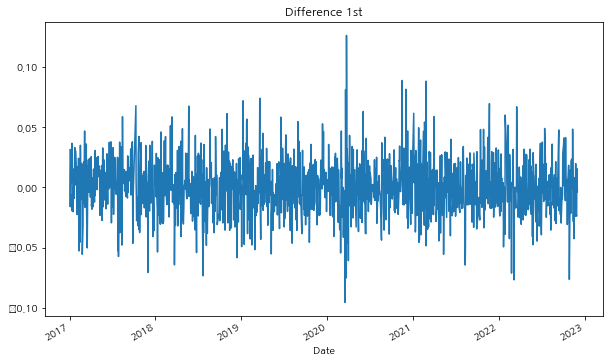

(-39.34651538172536, 0.0, 0, 1449, {'1%': -3.4348709954268384, '5%': -2.863536715724964, '10%': -2.567833035595811}, -6713.321750832898)
Results of Dickey-Fuller Test:
Test Statistic                  -39.346515
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1449.000000
Critical Value (1%)              -3.434871
Critical Value (5%)              -2.863537
Critical Value (10%)             -2.567833
dtype: float64

<< 2. s003540_log 종목의 d 구하기용 차분안정성확인입니다.>>


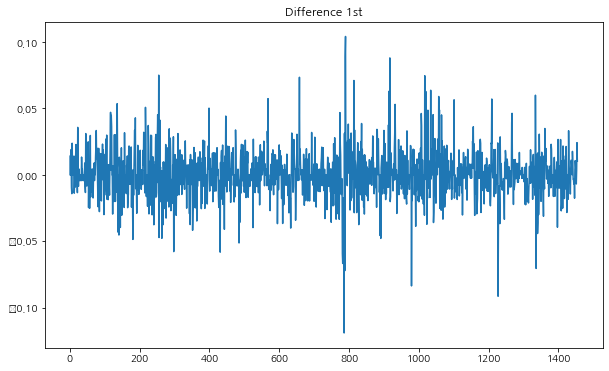

(-24.371421912815354, 0.0, 1, 1452, {'1%': -3.4348616379354793, '5%': -2.8635325860671696, '10%': -2.567830836482784}, -7345.601762452032)
Results of Dickey-Fuller Test:
Test Statistic                  -24.371422
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1452.000000
Critical Value (1%)              -3.434862
Critical Value (5%)              -2.863533
Critical Value (10%)             -2.567831
dtype: float64


In [11]:
# 차분 안정성 확인 -> d 구하기
for i,(k,v) in enumerate(stockdict_log.items()):
    print()
    print('='*80)
    print(f"<< {i}. {k} 종목의 d 구하기용 차분안정성확인입니다.>>")
    diff_1 = v.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    plt.show()
    augmented_dickey_fuller_test(diff_1)

### STEP 6 : ARIMA 모델 훈련과 테스트
ARIMA 모델 빌드와 훈련
모델 테스트 및 플로팅
최종 예측 모델 정확도 측정(MAPE)

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# 종목별 model저장용 dict 생성
stock_log_model = {}

# Build and Train  Model
for i,(k,v) in enumerate(stock_log_data.items()):   # train data, test data
    if k.split('_')[-2] == 'train':
        print()
        print('='*80)
        print(f"<< {i}. {k} 종목의 train_data 로 모델학습합니다.>>")
        if k.split('_')[0] == 's207940':
            p,d,q = 2,0,1
        elif k.split('_')[0] == 's000660':
            p,d,q = 1,0,0
        elif k.split('_')[0] == 's003540':    
            p,d,q = 1,0,0  #2,0,1
            
        stock_log_model[k + '_model'] = ARIMA(v, order=(p, d, q))  
        stock_log_model[k + '_fitted_m'] = stock_log_model[k + '_model'].fit() 
        print(f"stock_log_model[{k}_fitted_m].summary", stock_log_model[k + '_fitted_m'].summary())


<< 0. s207940_log_train_data 종목의 train_data 로 모델학습합니다.>>


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

stock_log_model[s207940_log_train_data_fitted_m].summary                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1305
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2841.543
Date:                Sun, 18 Dec 2022   AIC                          -5673.085
Time:                        04:10:34   BIC                          -5647.216
Sample:                             0   HQIC                         -5663.381
                               - 1305                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9221      0.500     25.822      0.000      11.941      13.903
ar.L1          0.0455      0.102      0.445      0.656      -0.155       0

k: s207940_log_train_data_fitted_m
k1: s207940_log_test_data

<< 1. s207940_log_train_data_fitted_m 종목의 모델이 Forcast 합니다.>>


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


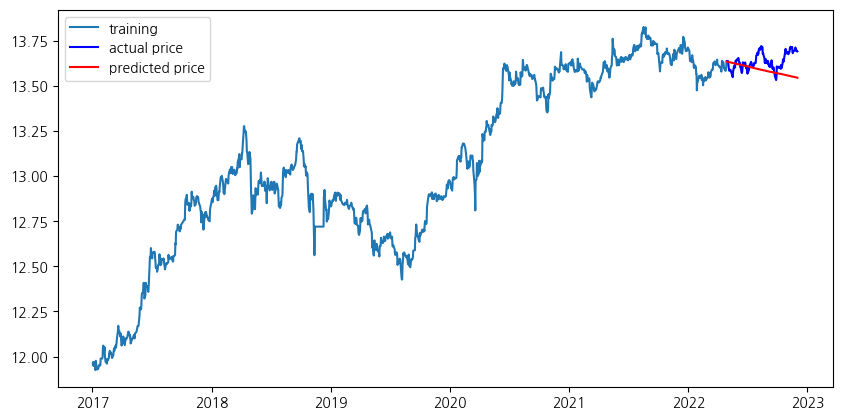

k: s000660_log_train_data_fitted_m
k1: s000660_log_test_data

<< 3. s000660_log_train_data_fitted_m 종목의 모델이 Forcast 합니다.>>


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


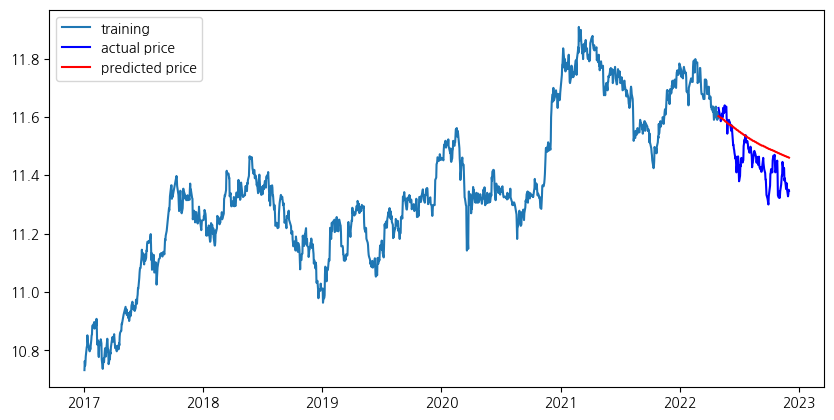

k: s003540_log_train_data_fitted_m
k1: s003540_log_test_data

<< 5. s003540_log_train_data_fitted_m 종목의 모델이 Forcast 합니다.>>


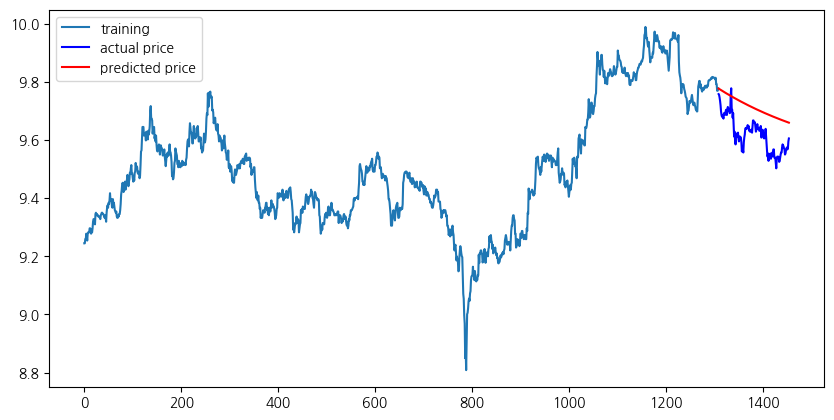

In [13]:
# Forecast : 결과가 fc에 담깁니다. 
# forcast 결과저장용 dict todtjd
stock_log_model_forcast = {}

for i,(k,v) in enumerate(stock_log_model.items()): # 종목별 학습된 모델들
    if k.split('_')[-2] == 'fitted':
        for k1,v1 in stock_log_data.items():
            if k1.split('_')[0] == k.split('_')[0] and k1.split('_')[-2] == 'test' :
                print("k:",k, end='\n') 
                print("k1:", k1)
                print()
                print('='*80)
                print(f"<< {i}. {k} 종목의 모델이 Forcast 합니다.>>")
                fc =  v.forecast(len(v1), alpha=0.05)  # 95% conf
                fc = np.array(fc)                               
                #Make as pandas series
                fc_series = pd.Series(fc, index= v1.index)   # 예측결과     
                stock_log_model_forcast[k1 + '_forcast'] = fc_series
    
                # Plot
                plt.figure(figsize=(10,5), dpi=100)
                plt.plot(stock_log_data[k1.split('_')[0] +'_' +  k1.split('_')[1] + '_train_data'], label='training')
                plt.plot(v1, c='b', label='actual price')
                plt.plot(stock_log_model_forcast[k1 + '_forcast'], c='r',label='predicted price')
                plt.legend()
                plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

stock_log_model_metric = {}
for k,v in stock_log_model_forcast.items():
    for k1,v1 in stock_log_data.items():
        #print("k:",k, end='\n')
        #print("k1:",k1)
        if k.split('_')[0] == k1.split('_')[0] and k1.split('_')[-2] == 'test':
            print("k:",k, end='\n')
            print("k1:",k1)
            mse = mean_squared_error(np.exp(v1), np.exp(v))
            print('MSE: ', mse)
            stock_log_model_metric[k + '_mse'] = mse
            mae = mean_absolute_error(np.exp(v1), np.exp(v))
            print('MAE: ', mae)
            stock_log_model_metric[k + '_mae'] = mae
    
            rmse = np.sqrt(mse)
            print('RMSE: ', rmse)
            stock_log_model_metric[k + '_rmse'] = rmse
    
            mape = np.mean(np.abs(np.exp(v) - np.exp(v1))/np.abs(np.exp(v1)))
            print('MAPE: {:.2f}%'.format(mape*100))
            stock_log_model_metric[k + '_mape'] = mape

print("Final_stock_log_model_metric",stock_log_model_metric)

k: s207940_log_test_data_forcast
k1: s207940_log_test_data
MSE:  4160018741.4739127
MAE:  49564.47273005138
RMSE:  64498.207273333675
MAPE: 5.76%
k: s000660_log_test_data_forcast
k1: s000660_log_test_data
MSE:  60371176.51261288
MAE:  6543.028526024826
RMSE:  7769.889092684199
MAPE: 7.22%
k: s003540_log_test_data_forcast
k1: s003540_log_test_data
MSE:  2435571.621146638
MAE:  1464.7985210120366
RMSE:  1560.6318019144162
MAPE: 9.91%
Final_stock_log_model_metric {'s207940_log_test_data_forcast_mse': 4160018741.4739127, 's207940_log_test_data_forcast_mae': 49564.47273005138, 's207940_log_test_data_forcast_rmse': 64498.207273333675, 's207940_log_test_data_forcast_mape': 0.0575676958621185, 's000660_log_test_data_forcast_mse': 60371176.51261288, 's000660_log_test_data_forcast_mae': 6543.028526024826, 's000660_log_test_data_forcast_rmse': 7769.889092684199, 's000660_log_test_data_forcast_mape': 0.07223171963939615, 's003540_log_test_data_forcast_mse': 2435571.621146638, 's003540_log_test_dat

### STEP 7 : 다른 주식 종목 예측해 보기
관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

* 삼성바이오로직스,sk하이닉스,대신증권 3종목을 대상으로 예측해 보았슴

## 회고

본 프로젝트는 주식 삼성바이오로직스,SK하이닉스, 대신증권 3개종목의 가격 예측모델을 만들기위해,미래예측데이터에 꼭 필요한 stationary를 확보하고, ARIMA모델을 이용하였으며,ACF, PACF챠트로 적절한 p,q를 모색하고,차분안정을위해 1차차분을 하고서,ARIMA모델로 학습을 해보았습니다'.'
학습결과 gkrtmqdms 및 예측을 해보고, 그 가격예측의 정확도를 MAE,MSE,RMSE< RAPE를 통해 평가해 보았습니다.

먼저, 삼성바이오로직스,sk하이닉스,대신증권 종목의 데이터 약 6년치((2017.1.1~2022.12.1))를 yahoo에서 다운받았고,
주가데이터의 특성상 시간이감에따라, 기울기가 높아지며, 변동폭이 증가하는 것의 안정화를 위해,1차적으로log로 전환하고서, 이동평균과 이동표준편차를 plotting하여, 
시각적인 안정여부를 체크하였으나, 대략 감은 잡지만, 구체적인 판단은 쉽지않아서,
2차적으로 정량적 안정화테스트를위해,ADF Test를 해보았는데, 세 종목 각각 p-value가 0.27, 0.083, 0.23으로서, 0.05 와는 격차가 있었습니다.

이를 안정화시키기위해서,
3차적으로,seasonal decompose메소드로,Time Series Decomposition을 하였는데,
이중 Residual의 p_value가 세종목 모두 소수점20자리가 넘는 값으로 거의 0에 가까워, Residual 데이터의 stationary가 확인되었습니다.

이제 이 데이터를 예측모델에 넣어 학습을 시켜야하는데,
STEP4에서 train, test data분리할때 잠시 혼동이 왔습니다.

모델은 공부한 ARIMA에 넣는데, Residual을 넣어야되는지, ts_log를 넣어야 하는지 혼동이 왔는데,
ARIMA 자체가 trend,seasonal을 처리해주는 기능이 내재되어 있으므로,ts_log로 넣는 것으로 했습니다.
STEP3까지는 statsmodel의 Decomposition으로 하는 방법을 익히는 공부였지,
그 결과를 ARIMA에 넣는것은 아닌것으로 보았는데, 맞는지 모르겠습니다.

STEP3의 Decomposition으로한 결과인 Residual을 쓸 경우, 어떤 모델로 써야할지,그리고,reconstruction 과정은 필요없는지 등이 궁금했는데,나중에 퍼실님을 통해 강사님께 문의하고 싶습니다.
 
ARIMA 모델의 parameter인 p,q 는  plot_acf, plot_pacf를, 여러번 p,q 변경하며, 차분변경을 통해서, d의 효과도 살피면서 보았는데, 결국 삽성바이오로직스는 (2,0,1) sk하이닉스는 (1,0,0) 대신증권도 (1,0,0)으로 했을때, 학습결과 Summary에 AIC 가    -5673.085, -6122.532, -6694.901로 낮게 나와서 일단 선택했습니다.

그런데,공부하다가 찾아본 잔차항에 관련되어, Summary의 잔차항분석에서는 세 종목 모두 Ljung-Box_Prob(Q), Jarque-Bera_Prob(JB),Heteroskedasticity_Prob(H)가 잔차가 자기상관성이 없고, 이분산성을 않띠지만, 첨도가 높은 비정규성 분포로 나와서, 모델에 어떤 예측오차 영향이 있을지 모르겠습니다.

최종적으로, 선정된 parameter를 입력후 학습된 ARIMA모델로 예측을 한 결과, 
평가지표는 다음과 같았습니다.

1. 삼성바이오로직스

MSE:  4160018741.4739127
MAE:  49564.47273005138
RMSE:  64498.207273333675

MAPE: 5.76%

2. sk하이닉스

MSE:  60371176.51261288
MAE:  6543.028526024826
RMSE:  7769.889092684199

MAPE: 7.22%

3. 대신증권

MSE:  2435571.621146638
MAE:  1464.7985210120366
RMSE:  1560.6318019144162

MAPE: 9.91%

내용 알찬 강의안 감사합니다.